In [1]:
import datetime
import random
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import lightgbm as lgb
import statistics as sts
import warnings
import urllib.request
import time
import random
import nltk
import os
import string
import pandas as pd
import numpy as np
import scipy.stats as sps
from sklearn import model_selection, linear_model, metrics, preprocessing
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings('ignore')
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Загрузка данных

In [2]:
df=pd.read_csv('Week_data.csv') 

# Нормализация данных

In [3]:
scaler=preprocessing.StandardScaler()
Norm_df = pd.DataFrame(np.hstack((scaler.fit_transform(df.iloc[:,:-1]),(df.iloc[:,-1]).to_numpy().reshape((-1,1)))),columns=df.columns)

# Просмотр наборов данных, его статистик

In [4]:
Norm_df.head(5)

,GAZP,SBER,SBERP,LKOH,GMKN,YNDX,NVTK,TATN,TATNP,ROSN,...,USDCNY,NYMEX.NG,INDUSDX,ICE.BRN,LME.Alum,LME.Nickel,comex.GC,comex.SI,D&J-IND,RTSI
0,-0.551786,-2.036850,-1.789882,-1.396443,-0.912634,-1.548931,-1.145312,-1.237417,-1.070500,-2.055907,...,-0.812149,-0.976793,0.999618,-2.017937,-1.865505,-1.430668,-2.354182,-1.831990,-1.732240,746.267
1,-0.706797,-2.196955,-1.885372,-1.539689,-1.140575,-1.790851,-1.180487,-1.310503,-1.127231,-2.314956,...,-0.691862,-1.170952,1.000641,-2.421641,-1.894072,-1.505344,-2.324352,-1.900246,-1.888805,686.814
2,-0.797634,-2.290135,-1.957728,-1.545550,-1.020642,-1.827678,-1.159415,-1.320335,-1.157575,-2.323933,...,-0.701485,-1.490236,1.099504,-2.576710,-1.835556,-1.384078,-2.276292,-1.796410,-1.991626,651.824
3,-0.591593,-2.119770,-1.913150,-1.332164,-0.933967,-1.733393,-1.005387,-1.186945,-1.149460,-1.857682,...,-0.706296,-1.315493,1.112458,-2.252284,-1.712764,-1.394013,-2.051155,-1.604712,-1.942181,708.384
4,-0.621136,-2.079738,-1.880972,-1.236155,-0.962942,-1.722151,-0.930560,-1.140734,-1.150165,-1.622632,...,-0.715919,-1.559271,0.718028,-2.120649,-1.674521,-1.485386,-1.735525,-1.427536,-1.881250,718.658


In [5]:
Norm_df.describe()

,GAZP,SBER,SBERP,LKOH,GMKN,YNDX,NVTK,TATN,TATNP,ROSN,...,USDCNY,NYMEX.NG,INDUSDX,ICE.BRN,LME.Alum,LME.Nickel,comex.GC,comex.SI,D&J-IND,RTSI
count,2.040000e+02,2.040000e+02,2.040000e+02,2.040000e+02,2.040000e+02,2.040000e+02,2.040000e+02,2.040000e+02,2.040000e+02,2.040000e+02,...,2.040000e+02,2.040000e+02,2.040000e+02,2.040000e+02,2.040000e+02,2.040000e+02,2.040000e+02,2.040000e+02,2.040000e+02,204.000000
mean,9.360704e-17,-3.515706e-16,3.058556e-16,1.980986e-16,-4.680352e-16,5.420501e-16,-5.387847e-16,5.986497e-17,-1.197299e-16,-3.461284e-16,...,-1.139611e-15,-1.254443e-15,6.616712e-15,4.405517e-16,-6.503512e-16,4.680352e-16,4.286332e-15,1.600027e-16,-5.572884e-16,1115.760480
std,1.002460e+00,1.002460e+00,1.002460e+00,1.002460e+00,1.002460e+00,1.002460e+00,1.002460e+00,1.002460e+00,1.002460e+00,1.002460e+00,...,1.002460e+00,1.002460e+00,1.002460e+00,1.002460e+00,1.002460e+00,1.002460e+00,1.002460e+00,1.002460e+00,1.002460e+00,158.336166
min,-1.119228e+00,-2.290135e+00,-1.957728e+00,-1.545550e+00,-1.356086e+00,-1.827678e+00,-1.180487e+00,-1.320335e+00,-1.284480e+00,-2.323933e+00,...,-2.135304e+00,-2.437302e+00,-2.398549e+00,-2.576710e+00,-1.894072e+00,-1.704479e+00,-2.354182e+00,-1.900246e+00,-1.998058e+00,651.824000
25%,-5.627195e-01,-7.890437e-01,-8.494361e-01,-8.854939e-01,-7.937768e-01,-9.869660e-01,-7.937233e-01,-9.759636e-01,-1.021408e+00,-8.562489e-01,...,-6.942674e-01,-4.768324e-01,-6.055455e-01,-7.239106e-01,-7.001886e-01,-7.240461e-01,-6.646193e-01,-7.829159e-01,-8.354858e-01,1018.893000
50%,-3.058517e-01,8.480892e-02,1.937884e-01,-4.189850e-01,-2.009282e-01,1.750899e-01,-4.941117e-01,-2.488929e-01,-5.377028e-02,-2.982586e-01,...,3.707665e-02,2.852111e-02,5.342891e-02,2.423541e-02,8.170451e-03,-9.998623e-02,-1.106777e-01,4.686732e-02,3.034497e-01,1131.778000
75%,8.075117e-02,8.603977e-01,8.899974e-01,1.008878e+00,6.747066e-01,8.282930e-01,9.865963e-01,1.071614e+00,9.383822e-01,9.349259e-01,...,7.672178e-01,4.405703e-01,5.938527e-01,6.968721e-01,7.959529e-01,6.668166e-01,4.100443e-01,5.682275e-01,8.549517e-01,1206.792750
max,3.254794e+00,2.025752e+00,1.645607e+00,2.008044e+00,3.042525e+00,1.782144e+00,2.042923e+00,1.538814e+00,1.801116e+00,2.515555e+00,...,2.055490e+00,3.553591e+00,2.411998e+00,2.250662e+00,2.679189e+00,2.720068e+00,2.918902e+00,2.835564e+00,1.612925e+00,1471.770000


In [6]:
Norm_df.shape

(204, 55)

# Rolling

In [7]:
df_features=Norm_df.drop(columns='RTSI')
df_targets=Norm_df.drop(columns=Norm_df.columns[:-1])
df_r1=df_features.rolling(5,min_periods=1,axis=0).mean()
df_r2=df_features.rolling(7,min_periods=1,axis=0).mean()
df_r3=df_features.rolling(10,min_periods=1,axis=0).mean()
df_r4=df_features.rolling(12,min_periods=1,axis=0).mean()
def col_rename(df,num):
    columns=list(df.columns)
    for i in range(len(columns)):
        columns[i]=columns[i]+'_roll'+str(num)
    df.columns=columns
    return df
df_r1=col_rename(df_r1,5)
df_r2=col_rename(df_r2,7)
df_r3=col_rename(df_r3,10)
df_r4=col_rename(df_r4,12)
df_extended=pd.concat([df_features,df_r1,df_r2,df_r3,df_r4,df_targets],axis=1)

In [8]:
df_extended

,GAZP,SBER,SBERP,LKOH,GMKN,YNDX,NVTK,TATN,TATNP,ROSN,...,USDCNY_roll12,NYMEX.NG_roll12,INDUSDX_roll12,ICE.BRN_roll12,LME.Alum_roll12,LME.Nickel_roll12,comex.GC_roll12,comex.SI_roll12,D&J-IND_roll12,RTSI
0,-0.551786,-2.036850,-1.789882,-1.396443,-0.912634,-1.548931,-1.145312,-1.237417,-1.070500,-2.055907,...,-0.812149,-0.976793,0.999618,-2.017937,-1.865505,-1.430668,-2.354182,-1.831990,-1.732240,746.267
1,-0.706797,-2.196955,-1.885372,-1.539689,-1.140575,-1.790851,-1.180487,-1.310503,-1.127231,-2.314956,...,-0.752005,-1.073872,1.000129,-2.219789,-1.879789,-1.468006,-2.339267,-1.866118,-1.810523,686.814
2,-0.797634,-2.290135,-1.957728,-1.545550,-1.020642,-1.827678,-1.159415,-1.320335,-1.157575,-2.323933,...,-0.735165,-1.212660,1.033254,-2.338763,-1.865045,-1.440030,-2.318275,-1.842882,-1.870891,651.824
3,-0.591593,-2.119770,-1.913150,-1.332164,-0.933967,-1.733393,-1.005387,-1.186945,-1.149460,-1.857682,...,-0.727948,-1.238368,1.053055,-2.317143,-1.826974,-1.428526,-2.251495,-1.783339,-1.888713,708.384
4,-0.621136,-2.079738,-1.880972,-1.236155,-0.962942,-1.722151,-0.930560,-1.140734,-1.150165,-1.622632,...,-0.725542,-1.302549,0.986050,-2.277844,-1.796484,-1.439898,-2.148301,-1.712179,-1.887221,718.658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2.961056,1.154549,1.335292,1.833499,2.861155,0.671834,1.984596,1.169888,1.613051,1.178174,...,1.802888,-0.947129,0.719420,0.149416,-0.555645,2.292950,2.569897,0.923546,1.170944,1429.246
200,3.254794,1.210919,1.405115,1.992824,3.042525,0.777856,2.042923,1.344492,1.669947,1.676174,...,1.788854,-0.829196,0.719761,0.173577,-0.546583,2.304221,2.537378,0.946722,1.213832,1471.770
201,2.861671,1.191748,1.386270,1.988205,2.722912,0.808889,1.927183,1.280774,1.689500,1.710195,...,1.766802,-0.744161,0.721466,0.194318,-0.551114,2.288471,2.487228,0.936012,1.257160,1446.888
202,2.761064,1.162867,1.361070,2.003221,2.676551,1.529914,1.786435,1.201242,1.730077,1.603571,...,1.719890,-0.681059,0.714221,0.219764,-0.556797,2.215475,2.417202,0.871810,1.301395,1450.644


# График RTSI

In [9]:
targets=Norm_df['RTSI'].to_list()

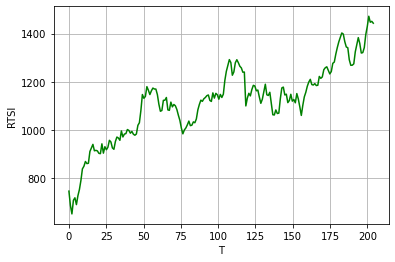

In [10]:
x=np.linspace(0,len(targets),len(targets))
fig, ax = plt.subplots()
ax.plot(x,targets,color='green')
ax.grid()
ax.set_xlabel('T')
ax.set_ylabel('RTSI')
plt.show()

# Корреляция

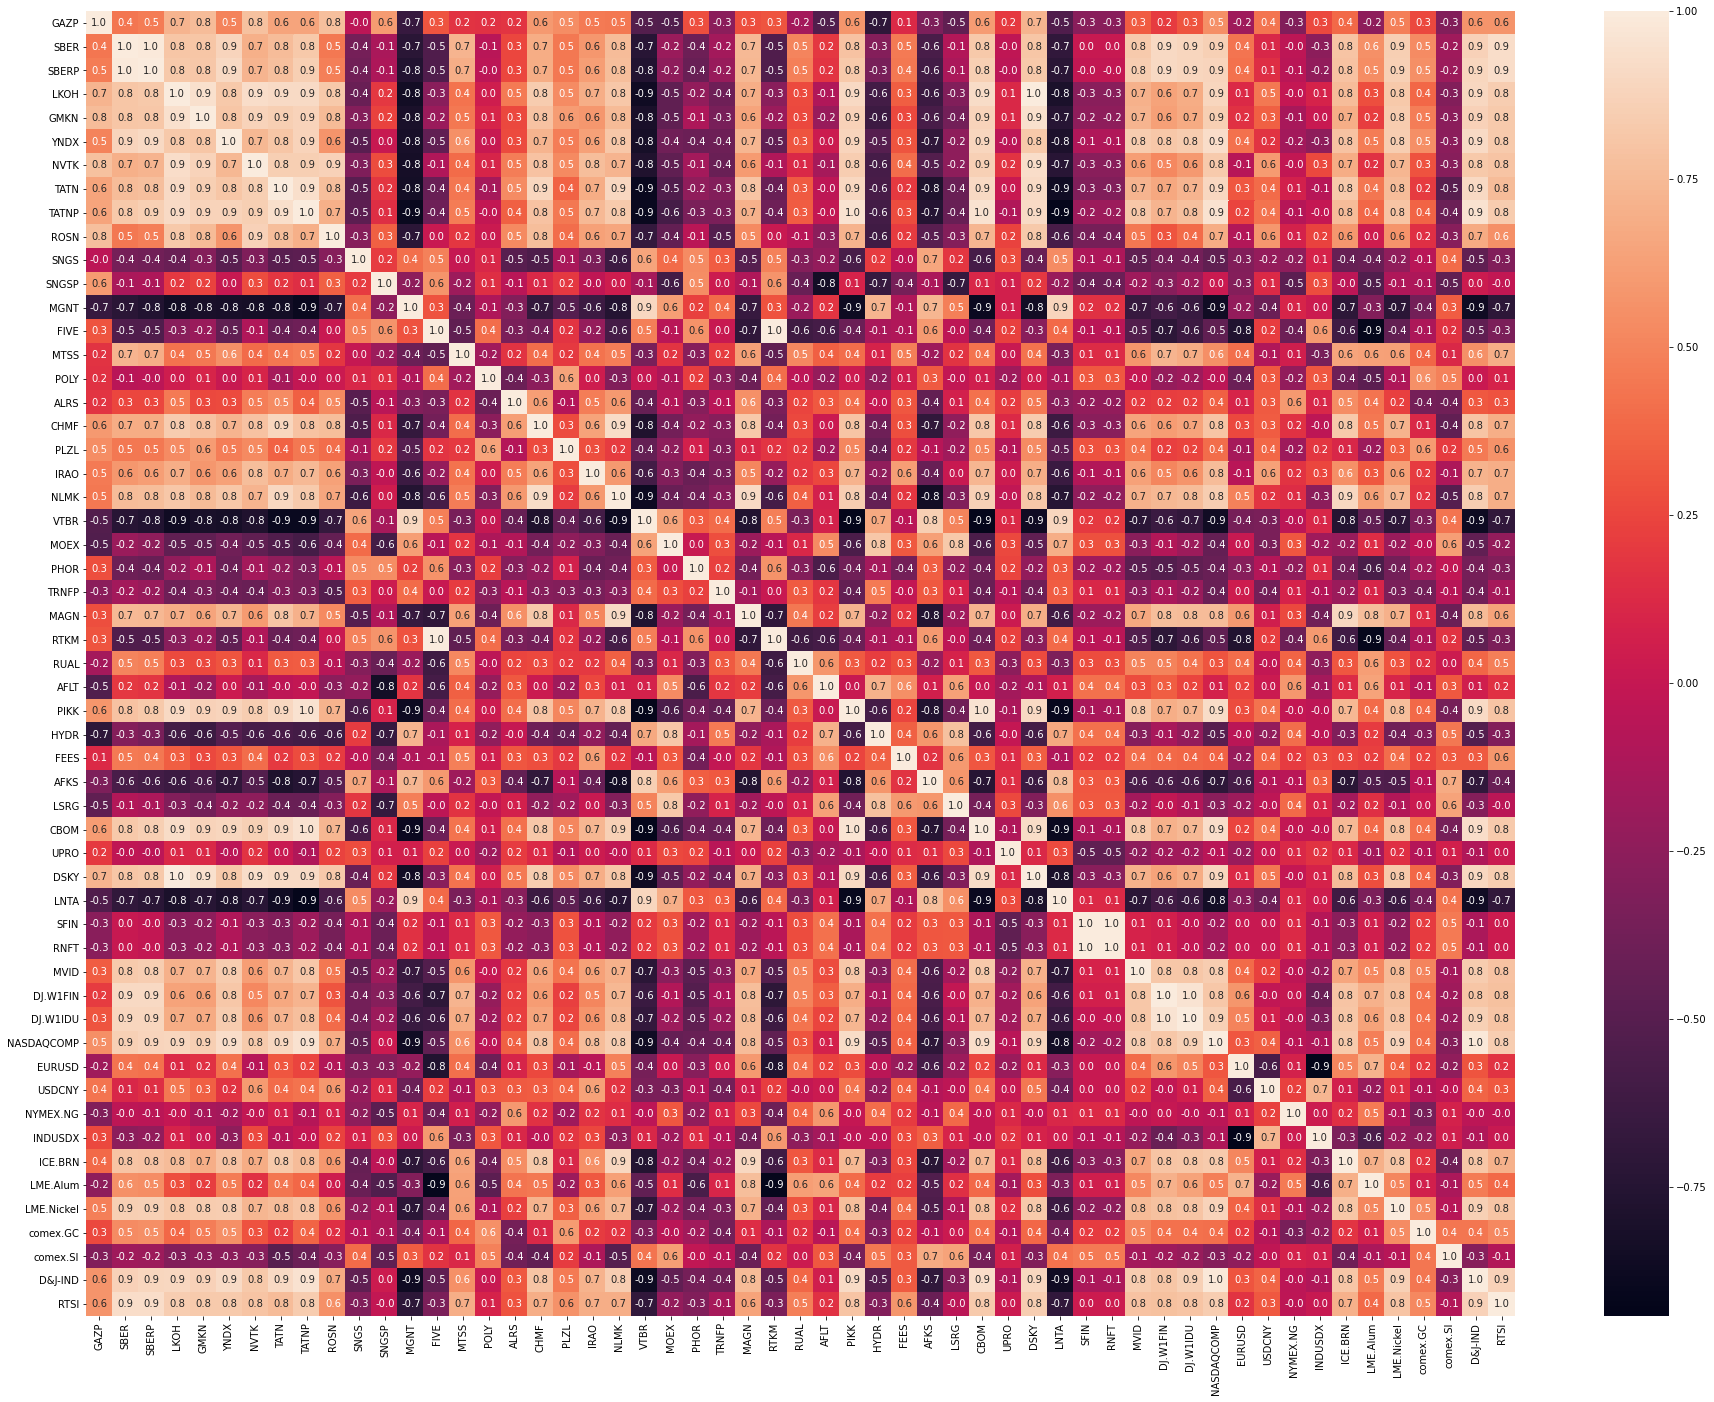

In [11]:
plt.figure(figsize=(32, 24)) 
sns.heatmap(Norm_df.corr(method='spearman'), annot=True, fmt=".1f");


In [12]:
#Данные по доп.признакам с нормализацией StandardScaler
add_feat_ds=Norm_df.iloc[:,42:]

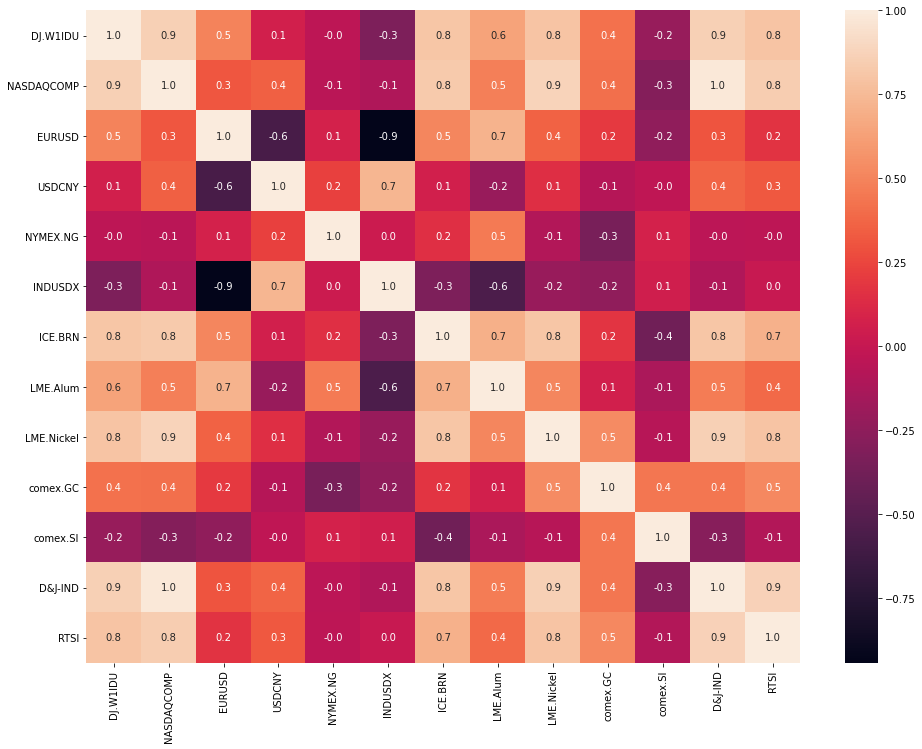

In [13]:
plt.figure(figsize=(16, 12))
sns.heatmap(add_feat_ds.corr(method='spearman'), annot=True, fmt=".1f");

In [14]:
extra=list(Norm_df.iloc[:,41:-1].columns)
basic=list(Norm_df.iloc[:,0:41].columns)

# Подготовка

In [15]:
the_lasso=linear_model.Lasso(random_state=7)
catmodel = CatBoostRegressor(verbose=False,random_state=7,max_depth=2)
lgbm_model=lgb.LGBMRegressor(random_state=7,max_depth=2)
#Кросс-Валидация по времени без ограничений на минимальное количество фолдов под обучающую выборку
tscv1=TimeSeriesSplit(n_splits=3)
#Кросс-Валидация по времени, фиксированное окно (не больше 140 в обучающей, 10 в тестовой)
tscv2=TimeSeriesSplit(n_splits=5,max_train_size=140,test_size=10)
#Кросс-Валидация по времени, фиксированное окно (не больше 140 в обучающей, 10 в тестовой)
tscv3=TimeSeriesSplit(n_splits=3,max_train_size=150,test_size=10)
#Разделение на обучающую и тестовую выборку
def train_test(df,test_size):
    x_cv, x_test =df.iloc[:len(df)-test_size,:-1], df.iloc[len(df)-test_size:,:-1]
    y_cv, y_test =df.iloc[:len(df)-test_size,-1], df.iloc[len(df)-test_size:,-1]
    return x_cv, x_test, y_cv, y_test
    


In [16]:
#Визуализация результатов прогнозирования 
def Graph_result(predicted,df,x_cv):
    train_len=len(x_cv)
    test_len=len(df)-len(x_cv)
    train_ind=np.linspace(0,train_len-1,train_len)
    test_ind=np.linspace(train_len,train_len+test_len-1,test_len)
    x=list((df['RTSI']).iloc[:train_len])
    y1=list((df['RTSI']).iloc[train_len:])
    y2=list(predicted)
    fig, ax = plt.subplots()
    ax.plot(np.linspace(0,len(df),len(df)), x+y1,color='green')
    ax.plot(test_ind, y2,color='red')
    ax.grid()
    ax.set_xlabel('T')
    ax.set_ylabel('RTSI')
    plt.show()

In [17]:
#Обобщенный шаблон обучения, предсказания и визуализации прогноза
def the_prediction(df, test_size, tscv, params, model):
    x_cv, x_test, y_cv, y_test = train_test(df, test_size)
    grid_cv=model_selection.GridSearchCV(model, params,scoring='r2',cv=tscv)
    grid_cv.fit(x_cv,y_cv)
    print('Лучшие значения гиперпараметров для модели', grid_cv.best_params_)
    print('Лучшее значение R2-метрики', grid_cv.best_score_)
    grid_cv.predict(x_test)
    print(metrics.r2_score(y_test, grid_cv.predict(x_test)))
    Graph_result(grid_cv.predict(x_test),df,x_cv)
    #return grid_cv.predict(x_test)

# Линейная Регрессия

In [18]:
#Сетка параметров 
par_grid_lasso = {
    'max_iter' : np.arange(3,30),
    'alpha' : np.linspace(0.0001,3,50),

}

Лучшие значения гиперпараметров для модели {'alpha': 0.36743469387755096, 'max_iter': 18}
Лучшее значение R2-метрики 0.25667683420745835
0.5609941739247191


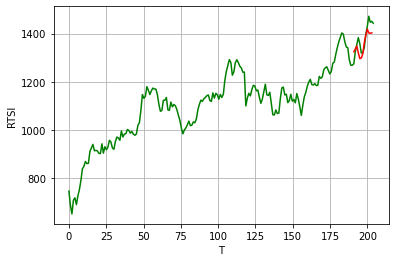

Wall time: 1min 11s


In [29]:
%%time
the_prediction(Norm_df[basic+['RTSI']],13,tscv2,par_grid_lasso,the_lasso)

Лучшие значения гиперпараметров для модели {'alpha': 0.12254489795918366, 'max_iter': 29}
Лучшее значение R2-метрики 0.307296748615985
0.43296049385655677


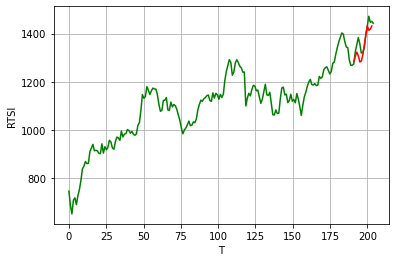

Wall time: 2min 13s


In [27]:
%%time
the_prediction(df_extended,13,tscv2,par_grid_lasso,the_lasso)

Лучшие значения гиперпараметров для модели {'alpha': 0.06132244897959183, 'max_iter': 29}
Лучшее значение R2-метрики 0.3190106534014353
0.5182903596387773


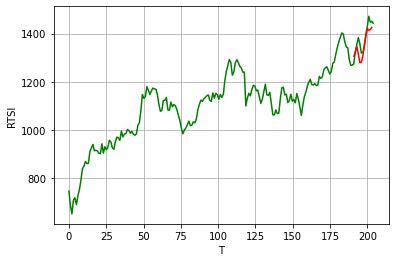

Wall time: 1min 9s


In [28]:
%%time
the_prediction(Norm_df,13,tscv2,par_grid_lasso,linear_model.Lasso())

# Light GBM

In [21]:
# Сетка параметров 
par_grid_lgbm = {
    'n_estimators' : [2000,4000],
    'reg_lambda': [1e-3,1e-2,1e-1],
    'reg_alpha' : np.array([1e-01,1e-02,1e-03]),

}

Лучшие значения гиперпараметров для модели {'n_estimators': 4000, 'reg_alpha': 0.001, 'reg_lambda': 0.001}
Лучшее значение R2-метрики -1.2585399926464205
-0.0447575188163889


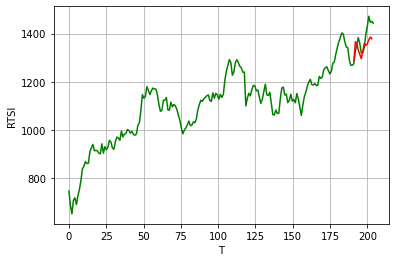

Wall time: 1min


In [22]:
%%time
the_prediction(Norm_df[basic+['RTSI']],13,tscv2,par_grid_lgbm,lgbm_model)

Лучшие значения гиперпараметров для модели {'n_estimators': 4000, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
Лучшее значение R2-метрики -1.2670382734431793
-0.3873929643477665


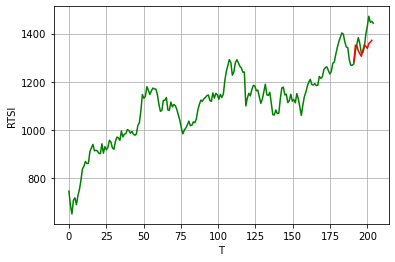

Wall time: 1min 13s


In [23]:
%%time
the_prediction(Norm_df,13,tscv2,par_grid_lgbm,lgbm_model)

# Catboost

In [24]:
#Сетка параметров 2
par_grid_cat = {
    'reg_lambda' : np.array([1e-03,1e-04]),
    'num_trees': np.array([2000,4000]),

}

Лучшие значения гиперпараметров для модели {'num_trees': 4000, 'reg_lambda': 0.0001}
Лучшее значение R2-метрики -1.8794461290092097
-0.896598904077339


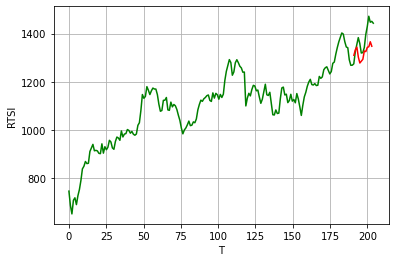

Wall time: 1min 27s


In [25]:
%%time
the_prediction(Norm_df[basic+['RTSI']],13,tscv2,par_grid_cat,catmodel)

Лучшие значения гиперпараметров для модели {'num_trees': 2000, 'reg_lambda': 0.001}
Лучшее значение R2-метрики -1.6513145227949528
-1.2026660326686547


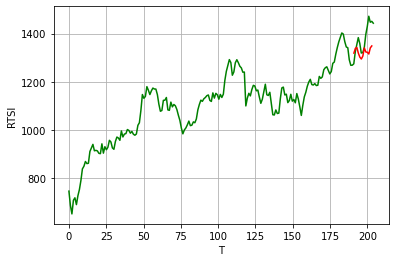

Wall time: 1min 41s


In [26]:
%%time
the_prediction(Norm_df,13,tscv2,par_grid_cat,catmodel)

In [32]:
week_titles=pd.read_csv('week_titles.csv')

In [33]:
week_titles

,date,title
0,2016-01-01,Запрет туркам вести строительство в России вст...
1,2016-01-10,Завод Nissan в Петербурге сократит 250 сотрудн...
2,2016-01-17,Иран заявил о намерении купить 114 самолетов A...
3,2016-01-24,В России нашелся инвестор для реализации проек...
4,2016-01-31,Владимир Путин списал долг Монголии\tПодрядчик...
...,...,...
199,2019-10-27,Сбербанк запустил приложение SberFood для похо...
200,2019-11-03,Песков заявил о возможности реализации «Северн...
201,2019-11-11,Крупнейшая сделка в истории оказалась во власт...
202,2019-11-17,Во Франции рассказали о «дедолларизации» Росси...


In [39]:
def the_tokenize(text):
    tokens=word_tokenize(text,language='russian')
    tokens_not_punkt=[i for i in tokens if i not in string.punctuation]
    tokens_not_punkt_or_stop=[i for i in tokens_not_punkt if i not in stopwords.words('russian')]
    long_words=[i for i in tokens_not_punkt_or_stop if len(i)>2]
    not_digit_words=[i for i in long_words if i.isalpha()]
    snowball=SnowballStemmer(language='russian')
    stemmed_tokens=[snowball.stem(i) for i in not_digit_words]
    return stemmed_tokens
    

In [57]:
v=TfidfVectorizer(tokenizer=lambda x: the_tokenize(x))
features=v.fit_transform(week_titles['title'])
features.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [66]:
features.shape

(204, 10527)

In [67]:
title_f_names=list()
def title_name(i):
    return 'text_feat'+str(i)
for i in range(features.shape[1]):
    title_f_names.append(title_name(i))

In [68]:
len(title_f_names)

10527

In [64]:
def numpy_transform(sparse_arr):
    a=np.zeros((sparse_arr.shape[0],sparse_arr.shape[1]),dtype=np.float64)
    for i in range(sparse_arr.shape[0]):
        for j in range(sparse_arr.shape[1]):
            a[i,j]=sparse_arr[i,j]
    return a

In [69]:
extended_features=pd.DataFrame(numpy_transform(features),columns=title_f_names)

In [70]:
df_full=pd.concat([df_features,df_r1,df_r2,df_r3,df_r4,extended_features,df_targets],axis=1)

Лучшие значения гиперпараметров для модели {'alpha': 0.12254489795918366, 'max_iter': 29}
Лучшее значение R2-метрики 0.30573458053990094
0.4329705566217533


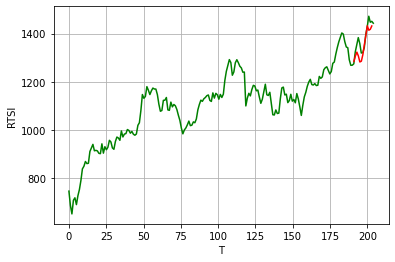

Wall time: 20min 1s


In [71]:
%%time
the_prediction(df_full,13,tscv2,par_grid_lasso,the_lasso)

In [72]:
df_full.shape

(204, 10798)